<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw4/hw4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## General Tips
In each homework problem, you will implement and train various diffusion models.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [1]:
!curl "https://drive.usercontent.google.com/download?id=1Bk0v3QeGEA8-zRJ6S_me3an6dWJ7KCh8&confirm=xxx" -o data/hw4_data.zip
!unzip -o -qq data/hw4_data.zip -d data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.7M  100 16.7M    0     0  2145k      0  0:00:08  0:00:08 --:--:-- 4561k


In [2]:
!pip install ..

Processing /home/ubuntu/Documents/CS294-158
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=78208 sha256=952a5f20b961e2584d733a93412b3dc09f46eb6e72e51b998fd9e25ccae6383a
  Stored in directory: /home/ubuntu/.cache/pip/wheels/c4/35/f7/51059a038a194a56ffe68cd93d07d72614887c5129182f6f52
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [3]:
import numpy as np

import torch
from torch.utils.data import DataLoader

from deepul.hw4_helper import (
    train,
    # Q1
    visualize_q1_dataset,
    q1_save_results,
    # Q2
    visualize_q2_data,
    q2_save_results,
    # Q3
    visualize_q3_data,
    q3a_save_results,
    q3b_save_results,
    q3c_save_results
)

In [4]:
from deepul.models.diffusion import TimeMLP, TimeUnet, TimeViT, GaussianDiffusion, ConditionalGaussianDiffusion

from deepul.data.utils import LabeledDataset

# Question 1: Toy Dataset [30pt]

In this question, we will train a simple diffusion models a toy 2D dataset.

Execute the cell below to visualize our datasets.

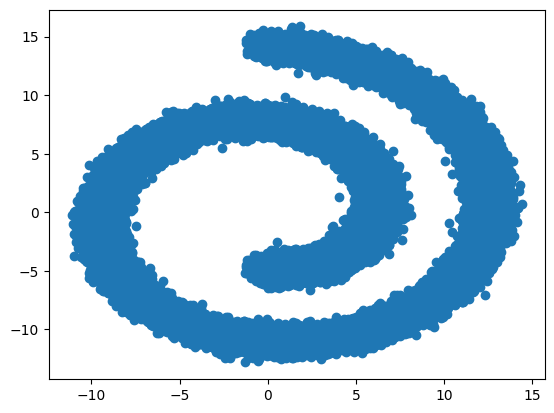

In [5]:
visualize_q1_dataset()

For code simplicity, we will train a continuous-time variant of the diffusion prompt. In practice training objectives and code between discrete-time and continuous-time diffusion models are similar.

Given a data element $x$ and neural net $f_\theta(x, t)$, implement the following diffusion training steps:
1. Sample the diffusion timestep: $t \sim \text{Uniform}(0, 1)$
2. Compute the noise-strength following a cosine schedule: $\alpha_t = \cos\left(\frac{\pi}{2}t\right), \sigma_t = \sin\left(\frac{\pi}{2}t\right)$
3. Apply the forward process - Sample noise $\epsilon \sim N(0,I)$ (same shape as $x$) and compute noised $x_t = \alpha_t x + \sigma_t \epsilon$
4. Estimate $\hat{\epsilon} = f_\theta(x_t, t)$
5. Optimize the loss $L = \lVert \epsilon - \hat{\epsilon} \rVert_2^2$. Here, it suffices to just take the mean over all dimensions.

Note that for the case of continuous-time diffusion, the forward process is $x_{0\to1}$ and reverse process is $x_{1\to0}$

Use an MLP for $f_\theta$ to optimize the loss. You may find the following details helpful.
* Normalize the data using mean and std computed from the train dataset
* Train 100 epochs, batch size 1024, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* MLP with 4 hidden layers and hidden size 64
* Condition on t by concatenating it with input x (i.e. 2D x + 1D t = 3D cat(x, t))

To sample, implement the standard DDPM sampler. You may find the equation from the [DDIM paper](https://arxiv.org/pdf/2010.02502.pdf) helpful, rewritten and re-formatted here for convenience.
$$x_{t-1} = \alpha_{t-1}\left(\frac{x_t - \sigma_t\hat{\epsilon}}{\alpha_t}\right) + \sqrt{\sigma_{t-1}^2 - \eta_t^2}\hat{\epsilon} + \eta_t\epsilon_t$$
where $\epsilon_t \sim N(0, I)$ is random Gaussian noise. For DDPM, let
$$\eta_t = \sigma_{t-1}/\sigma_t\sqrt{1 - \alpha_t^2/\alpha_{t-1}^2}$$
To run the reverse process, start from $x_1 \sim N(0, I)$ and perform `num_steps` DDPM updates (a hyperparameter), pseudocode below.
```
ts = linspace(1 - 1e-4, 1e-4, num_steps + 1)
x = sample_normal
for i in range(num_steps):
    t = ts[i]
    tm1 = ts[i + 1]
    eps_hat = model(x, t)
    x = DDPM_UPDATE(x, eps_hat, t, tm1)
return x
```
Note: If you encounter NaNs, you may need to clip $\sigma_{t-1}^2 - \eta_t^2$ to 0 if it goes negative, as machine precision issues can make it a very small negative number (e.g. -1e-12) if its too close to 0

In [6]:
def q1(train_data, test_data, n_layers=4, n_hiddens=64, n_samples=2000,
       batch_size=1024, epochs=100, lr=1e-3, cos_decay=True, device=None):
    """
    train_data: A (n_train, 2) numpy array of 2D points
    test_data: A (n_test, 2) numpy array of 2D points

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training
        and the end of every epoch
    - a numpy array of size (9, n_samples, 2) of samples drawn from your model.
        Draw n_samples samples for each of 9 different number of diffusion sampling steps
        of evenly logarithmically spaced integers 1 to 512
        hint: np.power(2, np.linspace(0, 9, 9)).astype(int)
    """

    """ YOUR CODE HERE """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    loc, scale = train_data.mean(0), train_data.std(0)
    train_data = (train_data - loc) / scale
    test_data = (test_data - loc) / scale
    _, d = train_data.shape

    net = TimeMLP(dim=n_hiddens, in_dim=d, num_layers=n_layers)
    model = GaussianDiffusion(model=net, objective='pred_noise', alpha_schedule='cosine').to(device)
    train_loader = DataLoader(torch.FloatTensor(train_data), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(torch.FloatTensor(test_data), batch_size=batch_size)
    train_losses, test_losses = train(model, train_loader, test_loader,
        lr=lr, epochs=epochs, cos_decay=cos_decay)

    sampling_steps = np.power(2, np.linspace(0, 9, 9)).astype(int)
    all_samples = []
    for steps in sampling_steps:
        all_samples.append(model.sample(n=n_samples, steps=steps))
    all_samples = np.stack(all_samples)

    all_samples = all_samples * scale + loc
    return train_losses, test_losses, all_samples

Epoch 1, Test loss 0.5105
Epoch 2, Test loss 0.4745
Epoch 3, Test loss 0.4738
Epoch 4, Test loss 0.4507
Epoch 5, Test loss 0.4405
Epoch 6, Test loss 0.4399
Epoch 7, Test loss 0.4314
Epoch 8, Test loss 0.4401
Epoch 9, Test loss 0.4214
Epoch 10, Test loss 0.4480
Epoch 11, Test loss 0.4262
Epoch 12, Test loss 0.4371
Epoch 13, Test loss 0.4313
Epoch 14, Test loss 0.4333
Epoch 15, Test loss 0.4251
Epoch 16, Test loss 0.4260
Epoch 17, Test loss 0.4190
Epoch 18, Test loss 0.4289
Epoch 19, Test loss 0.4205
Epoch 20, Test loss 0.4337
Epoch 21, Test loss 0.4253
Epoch 22, Test loss 0.4360
Epoch 23, Test loss 0.4337
Epoch 24, Test loss 0.4374
Epoch 25, Test loss 0.4173
Epoch 26, Test loss 0.4238
Epoch 27, Test loss 0.4351
Epoch 28, Test loss 0.4277
Epoch 29, Test loss 0.4178
Epoch 30, Test loss 0.4381
Epoch 31, Test loss 0.4106
Epoch 32, Test loss 0.4318
Epoch 33, Test loss 0.4135
Epoch 34, Test loss 0.4371
Epoch 35, Test loss 0.4223
Epoch 36, Test loss 0.4304
Epoch 37, Test loss 0.4289
Epoch 38, 

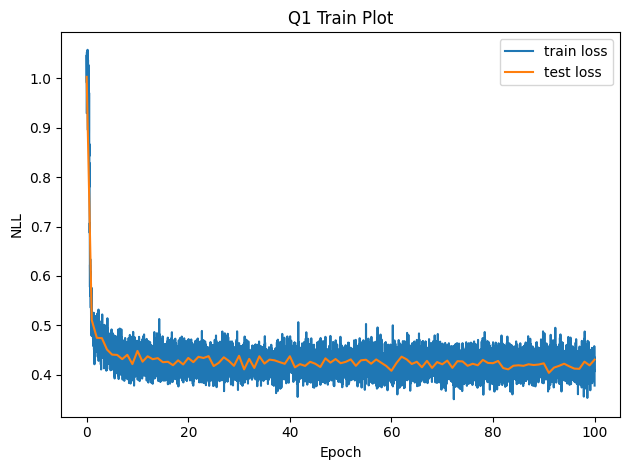

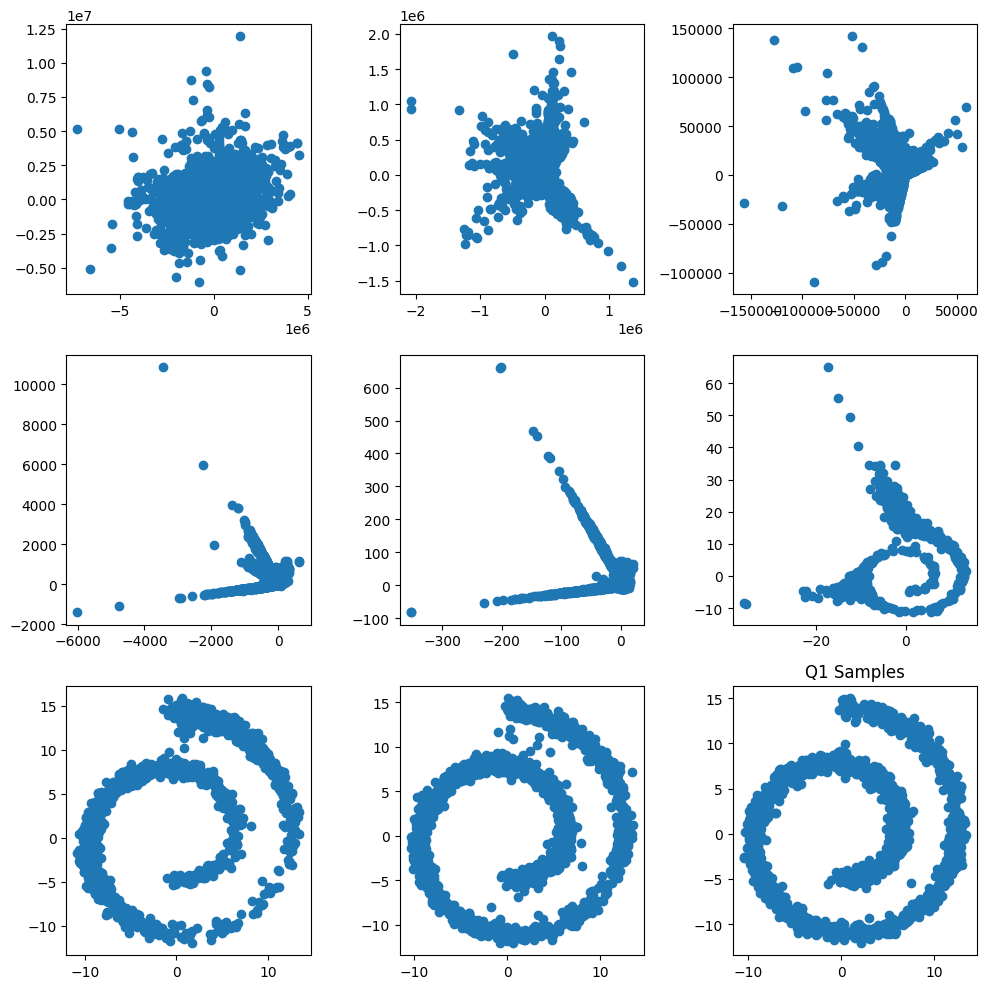

In [7]:
q1_save_results(q1)

# Question 2: Pixel-Space Diffusion on CIFAR-10 [30pt]

In this question, we will train pixel-space UNet diffusion model on CIFAR-10

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


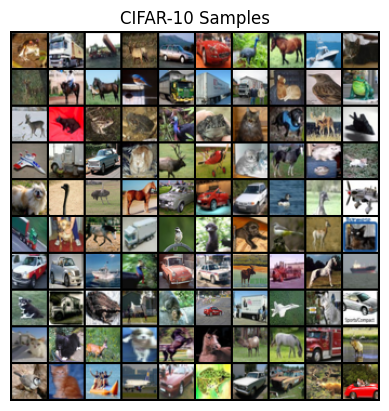

In [8]:
visualize_q2_data()

We'll use a UNet architecture similar to the original [DDPM](https://arxiv.org/abs/2006.11239) paper. We provide the following pseudocode for each part of the model:
```
def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = np.exp(-np.log(max_period) * np.arange(0, half, dtype=float32) / half)
    args = timesteps[:, None].astype(float32) * freqs[None]
    embedding = cat([np.cos(args), np.sin(args)], axis=-1)
    if dim % 2:
        embedding = cat([embedding, np.zeros_like(embedding[:, :1])], axis=-1)
    return embedding

ResidualBlock(in_channels, out_channels, temb_channels)
    Given x, temb
    h = Conv2d(in_channels, out_channels, 3, padding=1)(x)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    temb = Linear(temb_channels, out_channels)(temb)
    h += temb[:, :, None, None] # h is BxDxHxW, temb is BxDx1x1
    
    h = Conv2d(out_channels, out_channels, 3, padding=1)(h)
    h = GroupNorm(num_groups=8, num_channels=out_channels)(h)
    h = SiLU()(h)
    
    if in_channels != out_channels:
        x = Conv2d(in_channels, out_channels, 1)(x)
    return x + h
    
Downsample(in_channels)
    Given x
    return Conv2d(in_channels, in_channels, 3, stride=2, padding=1)(x)

Upsample(in_channels)
    Given x
    x = interpolate(x, scale_factor=2)
    x = Conv2d(in_channels, in_channels, 3, padding=1)(x)
    return x
    
UNet(in_channels, hidden_dims, blocks_per_dim)
    Given x, t
    temb_channels = hidden_dims[0] * 4
    emb = timestep_embedding(t, hidden_dims[0])
    emb = Sequential(Linear(hidden_dims[0], temb_channels), SiLU(), Linear(temb_channels, temb_channels))(emb)
    
    h = Conv2d(in_channels, hidden_dims[0], 3, padding=1)(x)
    hs = [h]
    prev_ch = hidden_dims[0]
    down_block_chans = [prev_ch]
    for i, hidden_dim in enumerate(hidden_dims):
        for _ in range(blocks_per_dim):
            h = ResidualBlock(prev_ch, hidden_dim, temb_channels)(h, emb)
            hs.append(h)
            prev_ch = hidden_dim
            down_block_chans.append(prev_ch)
        if i != len(hidden_dims) - 1:
            h = Downsample(prev_ch)(h)
            hs.append(h)
            down_block_chans.append(prev_ch)
    
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    h = ResidualBlock(prev_ch, prev_ch, temb_channels)(h, emb)
    
    for i, hidden_dim in list(enumerate(hidden_dims))[::-1]:
        for j in range(blocks_per_dim + 1):
            dch = down_block_chans.pop()
            h = ResidualBlock(prev_ch + dch, hidden_dim, temb_channels)(cat(h, hs.pop()), emb)
            prev_ch = hidden_dim
            if i and j == blocks_per_dim:
                h = Upsample(prev_ch)(h)
    
    h = GroupNorm(num_groups=8, num_channels=prev_ch)(h)
    h = SiLU()(h)
    out = Conv2d(prev_ch, in_channels, 3, padding=1)(h)
    return out
```

**Hyperparameter details**
* Normalize data to [-1, 1]
* UNET with hidden_dims as [64, 128, 256, 512] and 2 blocks_per_dim
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* For diffusion schedule, sampling and loss, use the same setup as Q1

You may also find it helpful to clip $\hat{x} = \frac{x_t - \sigma_t \hat{\epsilon}}{\alpha_t}$ to [-1, 1] during each sampling step.

In [5]:
def q2(train_data, test_data, dim_mults=(1, 2, 4, 8), n_hiddens=64, n_samples=10,
       batch_size=256, epochs=60, lr=1e-3, cos_decay=True, device=None):
    """
    train_data: A (n_train, 32, 32, 3) numpy array of images in [0, 1]
    test_data: A (n_test, 32, 32, 3) numpy array of images in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, n_samples, 32, 32, 3) of samples in [0, 1] drawn from your model.
        The array represents a 10 x n_samples grid of generated samples. Each row represents n_samples samples generated
        for a specific number of diffusion timesteps. Do this for 10 evenly logarithmically spaced integers
        1 to 512, i.e. np.power(2, np.linspace(0, 9, 10)).astype(int)
    """

    """ YOUR CODE HERE """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    train_data = np.transpose(train_data * 2 - 1, (0, 3, 1, 2))
    test_data = np.transpose(test_data * 2 - 1, (0, 3, 1, 2))
    _, c, h, w = train_data.shape

    net = TimeUnet(dim=n_hiddens, in_dim=c, dim_mults=dim_mults)
    model = GaussianDiffusion(model=net, size=(h, w), 
        objective='pred_noise', alpha_schedule='cosine', clip_range=(-1, 1)
    ).to(device)
    train_loader = DataLoader(torch.FloatTensor(train_data), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(torch.FloatTensor(test_data), batch_size=batch_size)
    train_losses, test_losses = train(model, train_loader, test_loader,
        lr=lr, epochs=epochs, cos_decay=cos_decay)

    sampling_steps = np.power(2, np.linspace(0, 9, 10)).astype(int)
    samples = []
    for steps in sampling_steps:
        samples.append(model.sample(n=n_samples, steps=steps))
    samples = np.stack(samples)

    samples = np.transpose((samples + 1) / 2, (0, 1, 3, 4, 2))
    return train_losses, test_losses, samples

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Test loss 0.0911
Epoch 2, Test loss 0.0800
Epoch 3, Test loss 0.0743
Epoch 4, Test loss 0.0715
Epoch 5, Test loss 0.0685
Epoch 6, Test loss 0.0665
Epoch 7, Test loss 0.0651
Epoch 8, Test loss 0.0643
Epoch 9, Test loss 0.0621
Epoch 10, Test loss 0.0645
Epoch 11, Test loss 0.0610
Epoch 12, Test loss 0.0625
Epoch 13, Test loss 0.0629
Epoch 14, Test loss 0.0606
Epoch 15, Test loss 0.0612
Epoch 16, Test loss 0.0613
Epoch 17, Test loss 0.0620
Epoch 18, Test loss 0.0590
Epoch 19, Test loss 0.0608
Epoch 20, Test loss 0.0583
Epoch 21, Test loss 0.0591
Epoch 22, Test loss 0.0584
Epoch 23, Test loss 0.0597
Epoch 24, Test loss 0.0600
Epoch 25, Test loss 0.0596
Epoch 26, Test loss 0.0606
Epoch 27, Test loss 0.0593
Epoch 28, Test loss 0.0608
Epoch 29, Test loss 0.0589
Epoch 30, Test loss 0.0589
Epoch 31, Test loss 0.0596
Epoch 32, Test loss 0.0587
Epoch 33, Test loss 0.0573
Epoch 34, Test loss 0.0590
Epoch 35, Test 

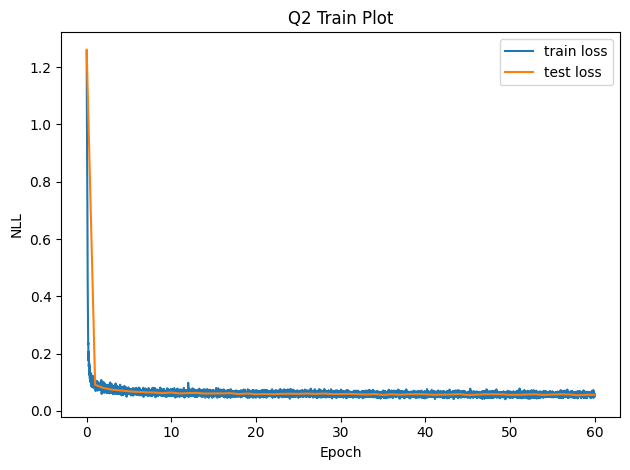

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


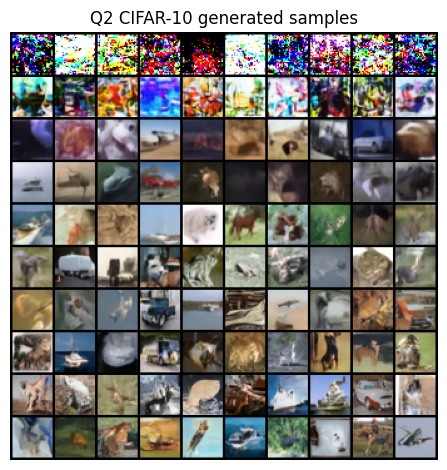

In [10]:
q2_save_results(q2)

# Question 3: Class-Conditional Latent-Space Diffusion on CIFAR-10 with DiT [60pt]

In this question, we will train latent-space [Diffusion Transformer (DiT)](https://arxiv.org/abs/2212.09748) model on CIFAR-10 **with class conditioning.**

Execute the cell below to visualize our datasets.

Files already downloaded and verified
Files already downloaded and verified


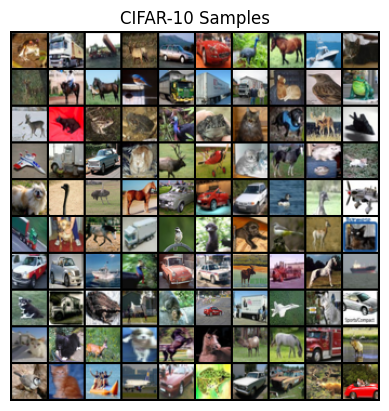

Labels:
 [[6 9 9 4 1 1 2 7 8 3]
 [4 7 7 2 9 9 9 3 2 6]
 [4 3 6 6 2 6 3 5 4 0]
 [0 9 1 3 4 0 3 7 3 3]
 [5 2 2 7 1 1 1 2 2 0]
 [9 5 7 9 2 2 5 2 4 3]
 [1 1 8 2 1 1 4 9 7 8]
 [5 9 6 7 3 1 9 0 3 1]
 [3 5 4 5 7 7 4 7 9 4]
 [2 3 8 0 1 6 1 1 4 1]]


In [5]:
visualize_q3_data()

## Part 3(a) VAE reconstructions and Scale Factor [10pt]

Similar to how we learned a AR model in VQGAN latent space for homework 1, in this question, you will train a diffusion model in the latent space of a VAE. Note that since diffusion models can model continuous distributions, we do not need a discretization bottleneck in the VAE, and the latent space itself is continuous.

Below, we specify each of the relevant properties or functions that you may need.

In [ ]:
# @property
# def latent_dim(self) -> int:
#     """The number of channels of the encoded representation"""
#
# def encode(self, x: np.ndarray) -> np.ndarray:
#     """Encode an image x. Note: Channel dim is in dim 1
#
#     Args:
#         x (np.ndarray, dtype=float32): Image to encode. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#
#     Returns:
#         np.ndarray: Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values
#     """
#
# def decode(self, z: np.ndarray) -> np.ndarray:
#     """Decode an encoded image.
#
#     Args:
#         z (np.ndarray, dtype=float32): Encoded image. shape=(batch_size, 4, 8, 8). Unbounded values.
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 3, 32, 32). Values in [-1, 1]
#     """
#

In this part, feed the given images through the VAE to compute and visualize reconstructions. In addition, you will compute a scale factor that will be needed during diffusion training to help normalize the data.

To estimate the scale factor, encode 1000 images into the VAE latent space, flatten the entire tensor along all dimensions, and compute the standard deviation.

In [5]:
def q3_a(images, vae, n_samples=50):
    """
    images: (batch_size, 32, 32, 3) numpy array in [0, 1], the images to pass through the encoder and decoder of the vae
    vae: a vae model, trained on the relevant dataset

    Returns
    - a numpy array of size (n_samples, 2, 32, 32, 3) of the decoded image in [0, 1] consisting of pairs
        of real and reconstructed images
    - a float that is the scale factor
    """

    """ YOUR CODE HERE """
    images = np.transpose(images * 2 - 1, (0, 3, 1, 2))

    latents = vae.encode(images)
    scale_factor = latents.std().item()

    ind_samples = np.random.choice(len(images), n_samples)
    reals = images[ind_samples]
    recons = vae.decode(latents[ind_samples])
    autoencoded_images = np.stack((reals, recons), axis=1)

    autoencoded_images = np.transpose((autoencoded_images + 1) / 2, (0, 1, 3, 4, 2))
    return autoencoded_images, scale_factor

Files already downloaded and verified
Files already downloaded and verified


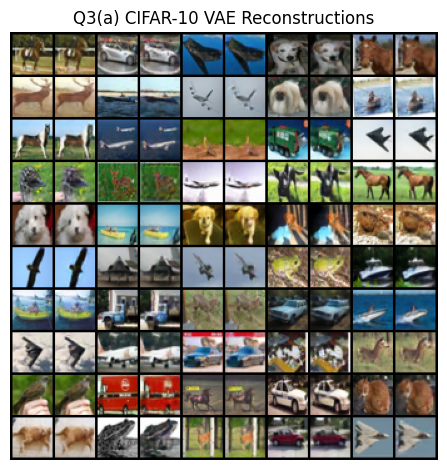

Scale factor: 1.2778


In [6]:
q3a_save_results(q3_a)

## Part 3(b) Diffusion Transformer [30pt]
In this part, you will train a Diffusion Transformer (Dit) on the latent space of the above pretrained VAE. You can use your Transformer implementation from HW1 as the core part of the DiT implementation.

Below, we outline the key modifications needed on top of the standard Transformer for DiT.
```
def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size):
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

DiTBlock(hidden_size, num_heads)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 6 * hidden_size)(c)
    shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = c.chunk(6, dim=1)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_msa, scale_msa)
    x = x + gate_msa.unsqueeze(1) * Attention(hidden_size, num_heads)(h)
    
    h = LayerNorm(hidden_size, elementwise_affine=False)(x)
    h = modulate(h, shift_mlp, scale_mlp)
    x = x + gate_mlp.unsqueeze(1) * MLP(hidden_size)(h)
    
    return x
    
FinalLayer(hidden_size, patch_size, out_channels)
    Given x (B x L x D), c (B x D)
    c = SiLU()(c)
    c = Linear(hidden_size, 2 * hidden_size)(c)
    shift, scale = c.chunk(2, dim=1)
    x = LayerNorm(hidden_size, elementwise_affine=False)(x)
    x = modulate(x, shift, scale)
    x = Linear(hidden_size, patch_size * patch_size * out_channels)(x)
    return x
    
DiT(input_shape, patch_size, hidden_size, num_heads, num_layers, num_classes, cfg_dropout_prob)
    Given x (B x C x H x W) - image, y (B) - class label, t (B) - diffusion timestep
    x = patchify_flatten(x) # B x C x H x W -> B x (H // P * W // P) x D, P is patch_size
    x += pos_embed # see get_2d_sincos_pos_embed
    
    t = compute_timestep_embedding(t) # Same as in UNet
    if training:
        y = dropout_classes(y, cfg_dropout_prob) # Randomly dropout to train unconditional image generation
    y = Embedding(num_classes + 1, hidden_size)(y)
    c = t + y
    
    for _ in range(num_layers):
        x = DiTBlock(hidden_size, num_heads)(x, c)
    
    x = FinalLayer(hidden_size, patch_size, out_channels)(x)
    x = unpatchify(x) # B x (H // P * W // P) x (P * P * C) -> B x C x H x W
    return x
```

**Hyperparameter details**
* Normalize image to [-1, 1], (2) Encode using the VAE, (3) divide latents by the scale_factor compute in part (a)
* Transformer with patch_size 2, hidden_size 512, num_heads 8, num_layers 12
* Train 60 epochs, batch size 256, Adam with LR 1e-3 (100 warmup steps, cosine decay to 0)
* When sampling, remember to multiple the final generated latents by the scale_factor before feeding it through the decoder
* For diffusion schedule, sampling and loss, use the same setup as Q1

For class conditioning, learn an embedding for each class, and an extra embedding to represent the null class. To condition, add the class embedding to the timestep embedding before feeding it into the transformer blocks (see pseudocode). **Train your class conditional diffusion models while dropping out the class (replace with null class) 10% of the time. This will be necessary for part (c).**

**Remember to save your model parameters after training, as you will need them for part (c)**

In [13]:
def q3_b(train_data, train_labels, test_data, test_labels, vae, scale_factor,
         n_hiddens=512, n_heads=8, n_layers=12, n_steps=512, n_samples=10,
         batch_size=256, epochs=60, lr=1e-3, cos_decay=True, device=None):
    """
    train_data: A (n_train, 32, 32, 3) numpy array of images in [0, 1]
    train_labels: A (n_train,) numpy array of class labels
    test_data: A (n_test, 32, 32, 3) numpy array of images in [0, 1]
    test_labels: A (n_test,) numpy array of class labels
    vae: a pretrained VAE
    scale_factor: a float that is the scale factor

    Returns
    - a (# of training iterations,) numpy array of train losses evaluated every minibatch
    - a (# of num_epochs + 1,) numpy array of test losses evaluated at the start of training and the end of every epoch
    - a numpy array of size (10, n_samples, 32, 32, 3) of samples in [0, 1] drawn from your model.
        The array represents a 10 x n_samples grid of generated samples. Each row represents n_samples samples generated
        for a specific class (i.e. row 0 is class 0, row 1 class 1, ...). Use n_steps diffusion timesteps
    """

    """ YOUR CODE HERE """
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    train_data = np.transpose(train_data * 2 - 1, (0, 3, 1, 2))
    test_data = np.transpose(test_data * 2 - 1, (0, 3, 1, 2))
    train_data = vae.encode(train_data) / scale_factor
    test_data = vae.encode(test_data) / scale_factor
    _, c, h, w = train_data.shape

    net = TimeViT(image_size=(h, w), patch_size=(h//4, w//4),
        dim=n_hiddens, in_dim=c, depth=n_layers, num_classes=10, attn_dim_head=n_heads)
    model = ConditionalGaussianDiffusion(
        model=net, size=(h, w), objective='pred_noise', alpha_schedule='cosine'
    ).to(device)
    train_loader = DataLoader(LabeledDataset(train_data, train_labels, dropout=0.1), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(LabeledDataset(test_data, test_labels), batch_size=batch_size)
    train_losses, test_losses = train(model, train_loader, test_loader,
        lr=lr, epochs=epochs, cos_decay=cos_decay, supervised=True)

    samples = []
    for label in range(10):
        sample = model.sample(n=n_samples, label=label, steps=n_steps)
        sample = vae.decode(sample * scale_factor)
        samples.append(sample)
    samples = np.stack(samples)

    samples = np.transpose((samples + 1) / 2, (0, 1, 3, 4, 2))
    return train_losses, test_losses, samples, model

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Test loss 0.4054
Epoch 2, Test loss 0.3945
Epoch 3, Test loss 0.3914
Epoch 4, Test loss 0.3898
Epoch 5, Test loss 0.3879
Epoch 6, Test loss 0.3830
Epoch 7, Test loss 0.3832
Epoch 8, Test loss 0.3811
Epoch 9, Test loss 0.3767
Epoch 10, Test loss 0.3793
Epoch 11, Test loss 0.3794
Epoch 12, Test loss 0.3732
Epoch 13, Test loss 0.3743
Epoch 14, Test loss 0.3741
Epoch 15, Test loss 0.3756
Epoch 16, Test loss 0.3759
Epoch 17, Test loss 0.3678
Epoch 18, Test loss 0.3691
Epoch 19, Test loss 0.3725
Epoch 20, Test loss 0.3676
Epoch 21, Test loss 0.3702
Epoch 22, Test loss 0.3671
Epoch 23, Test loss 0.3648
Epoch 24, Test loss 0.3662
Epoch 25, Test loss 0.3728
Epoch 26, Test loss 0.3674
Epoch 27, Test loss 0.3647
Epoch 28, Test loss 0.3626
Epoch 29, Test loss 0.3681
Epoch 30, Test loss 0.3637
Epoch 31, Test loss 0.3638
Epoch 32, Test loss 0.3658
Epoch 33, Test loss 0.3669
Epoch 34, Test loss 0.3617
Epoch 35, Test 

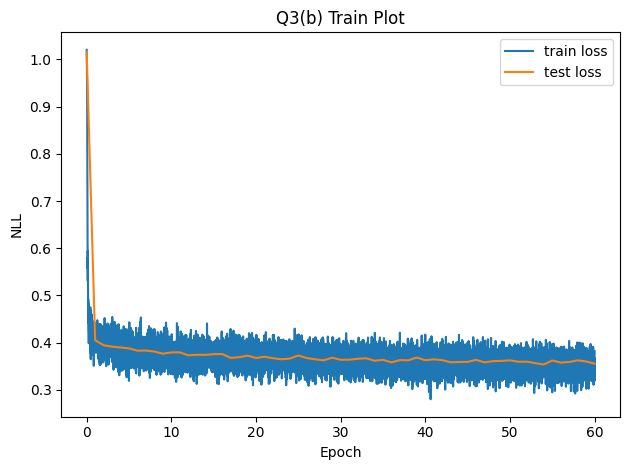

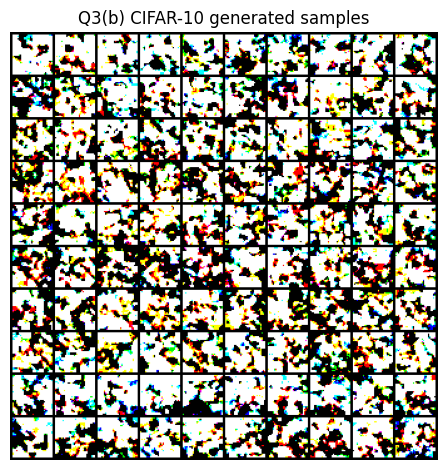

In [14]:
q3b_save_results(q3_b)

## Part 3(c) Classifier-Free Guidance [20pt]
In this part, you will implement [Classifier-Free Guidance](https://arxiv.org/abs/2207.12598) (CFG). CFG is a widely used method during diffusion model sampling to push samples towards more accurately aligning with the conditioning information (e.g. class, text caption).

Implement CFG requires a small modification to the diffusion sampling code. Given a CIFAR-10 class label, instead of using $\hat{\epsilon} = f_\theta(x_t, t, y)$ to sample, use:
$$\hat{\epsilon} = f_\theta(x_t, t, \varnothing) + w(f_\theta(x_t, t, y) - f_\theta(x_t, t, \varnothing))$$
where $w$ is a sampling hyperparameter that controls the strength of CFG. $\varnothing$ indicates the unconditional model with the class label dropped out, which your pre-trained UNet from 3(b) should support. Note that $w = 1$ recovers standard sampling.

Note: It may be expected to see worse samples (e.g. sautrated images) when CFG value is too high. Generation quality is closer to a U-shape when increasing CFG values (gets better, then worse)

In [5]:
net = TimeViT(image_size=(8, 8), patch_size=(2, 2),
              dim=512, in_dim=4, depth=12, num_classes=10, attn_dim_head=8)
model = ConditionalGaussianDiffusion(
    model=net, size=(8, 8), objective='pred_noise', alpha_schedule='cosine'
).cuda()
model.load_state_dict(torch.load("data/q3.pt"))

<All keys matched successfully>

In [11]:
def q3_c(model, vae, scale_factor, n_steps=512, n_samples=10):
    """
    vae: a pretrained vae

    Returns
    - a numpy array of size (4, 10, n_samples, 32, 32, 3) of samples in [0, 1] drawn from your model.
        The array represents a 4 x 10 x n_samples grid of generated samples - 4 10 x n_samples grid of samples
        with 4 different CFG values of w = {1.0, 3.0, 5.0, 7.5}. Each row of the 10 x n_samples grid
        should contain samples of a different class. Use n_steps diffusion sampling timesteps.
    """

    """ YOUR CODE HERE """
    all_samples = []
    for cfg in [1.0, 3.0, 5.0, 7.5]:
        samples = []
        for label in range(10):
            sample = model.sample(n=n_samples, label=label, steps=n_steps, cfg=cfg)
            sample = vae.decode(sample * scale_factor)
            samples.append(sample)
        samples = np.stack(samples)
        all_samples.append(samples)
    all_samples = np.stack(all_samples)

    all_samples = np.transpose((all_samples + 1) / 2, (0, 1, 2, 4, 5, 3))

    return all_samples

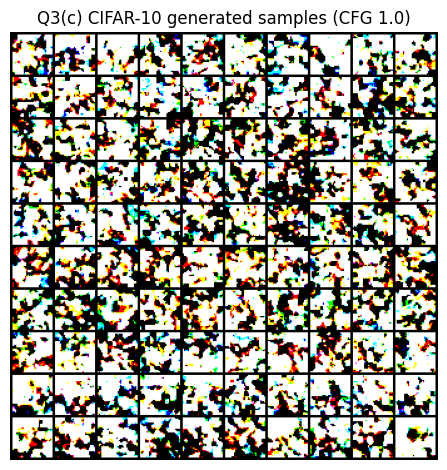

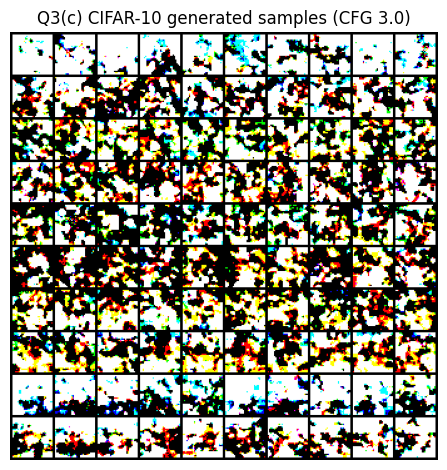

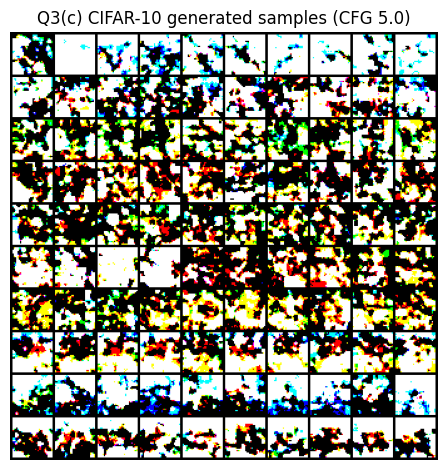

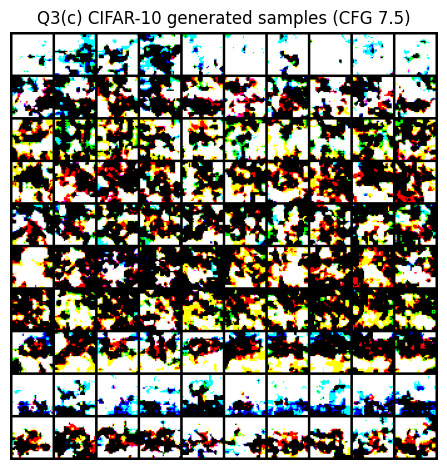

In [12]:
q3c_save_results(q3_c, model)